# What does this code do?
It reads your data which should include some ECG data. You need to input the sampling rate of the data
It converts it into an array called sig

Then it detrends any noise from movement etc by first using a polynomial detrending method and then uses discrete wavelet transform to decompose the signal into different components, including noise. Then it reconstructs the signal without noise.

While this process can handle certain types of noise, it cannot remove random peaks which may be caused by either due to movement, or other factors. 

To handle those, we will apply a manual filter, which if the detected peaks are negative values or less than 100mV, those are not real peaks.
Further, if two subsequent peaks have less than 45 (i.e., HR=150bpm) or more than 160 (HR=30bpm) rows in between, those will also be eliminated.

However, as you might also realize, this is not the best way, because we still don't know if the detected peaks are actual R peaks or not. 

Thus, next step is to create how dependable these peaks are by showing how many of the peaks were removed during the manual filtering method explained above. The more that got removed, the less trustworthy the data.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pywt
import wfdb.processing
##this library is from: https://www.samproell.io/posts/signal/ecg-library-comparison/

from datetime import datetime, timedelta, tzinfo
from dateutil import parser

In [2]:
# 1. Polynomial detrending (e.g., quadratic)
def detrend (subset,  order =3):
        x = np.arange(len(subset))
        coeffs = np.polyfit(x, subset, order)
        trend = np.polyval(coeffs, x)
        subset_detrended = subset - trend
        
        return subset_detrended


In [3]:
# 2. Noise reduction using discrete wavelet transform (DWT)
def remove_noise(signal, wavelet='sym4', level=1):
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    # Universal threshold (VisuShrink)
    sigma = np.median(np.abs(coeffs[-1])) / 0.6745
    threshold = sigma * np.sqrt(2 * np.log(len(signal)))
    coeffs_thresholded = [pywt.threshold(c, threshold, mode='soft') for c in coeffs]
    return pywt.waverec(coeffs_thresholded, wavelet)


In [4]:
# 3. Find rpeaks in the signal
def find_rpeaks(signal, fs=100):
    rpeaks = wfdb.processing.xqrs_detect(signal, fs=fs, verbose=False)
    return rpeaks

In [5]:
# 4. Find r-peaks in signal with correction
def find_rpeaks_corrected(signal, rpeaks, search_radius=100, smooth_window_size=20, fs=100):
    rpeaks_corrected = wfdb.processing.correct_peaks(
        signal, rpeaks, search_radius=search_radius, smooth_window_size=smooth_window_size, peak_dir="up"
    )

    n =  (signal[rpeaks_corrected] <= 100).sum() / signal[rpeaks_corrected].size * 100  # Calculate percentage of R-peaks with signal value <= 100 mV
    print(f"{n:.1f}% of the R-peaks have less than 100 mV signal value")  # Display percentage

    rpeaks_corrected = rpeaks_corrected[signal[rpeaks_corrected] > 100]  # Remove any indices with signal value below 100 mV

    return rpeaks_corrected

In [6]:
# 5. Find HR 
def find_hr(rpeaks, fs=100):
    diff = np.diff(rpeaks,1)
    n =  ((diff<160) & (diff>45)).sum() / diff.size *100
    #display 1 decimal place
    display(f"{n:.1f}% of the R-peaks are within the range of 45-160")

    diff = diff [(diff<160) & (diff>45)]

    HR = 60/(diff/fs) #beats per minute
    print("HR: ", f"{HR.mean():.0f}")  # Display mean HR rounded to nearest integer
    ## HRV: https://tryterra.co/blog/measuring-hrv-sdnn-and-rmssd-3a9b962f7314
    #SDRR
    SDRR = np.std(diff)
    print("SDRR:", f"{SDRR:.0f}")    # Display SDRR rounded to nearest integer

    # RMSSD
    SSD = diff * diff
    MSSD = np.mean(SSD)
    RMSSD = np.sqrt(MSSD)
    print("RMSSD: ", f"{RMSSD:.0f}")  # Display RMSSD rounded to nearest integer

    return HR, SDRR, RMSSD

In [7]:
#read data
file = "P5_S1.csv"
data = pd.read_csv((file))

#sampling rate
fs= 100

In [8]:
sig = np.squeeze(np.array(data["Physio_ECG"].iloc[91000:92000]))

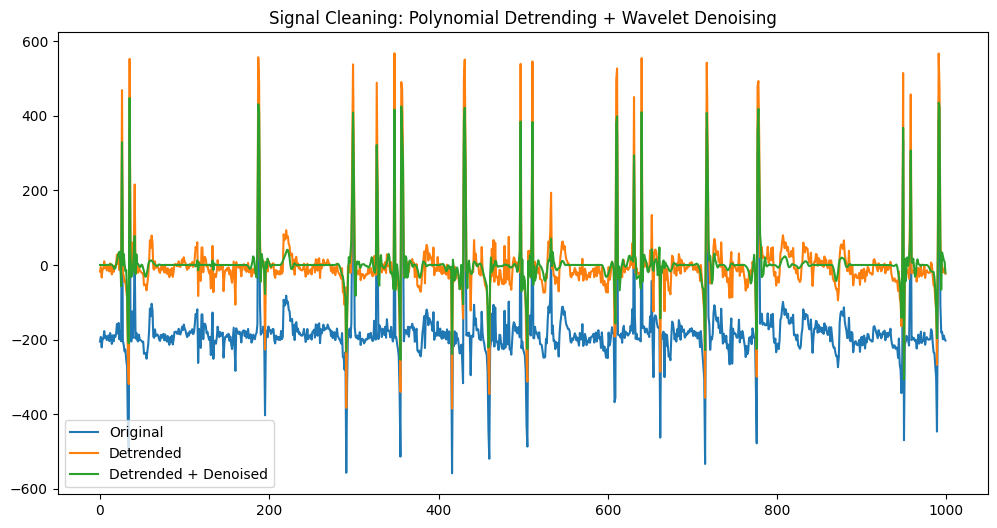

In [9]:
subset_detrended = detrend(sig, order=3)
# Apply wavelet denoising
subset_clean = remove_noise(subset_detrended, wavelet="db4", level=2)

# Optional: plot results
plt.figure(figsize=(12,6))
plt.plot(sig, label='Original')
plt.plot(subset_detrended, label='Detrended')
plt.plot(subset_clean, label='Detrended + Denoised')
plt.legend()
plt.title('Signal Cleaning: Polynomial Detrending + Wavelet Denoising')
plt.show()

7.1% of the R-peaks have less than 100 mV signal value


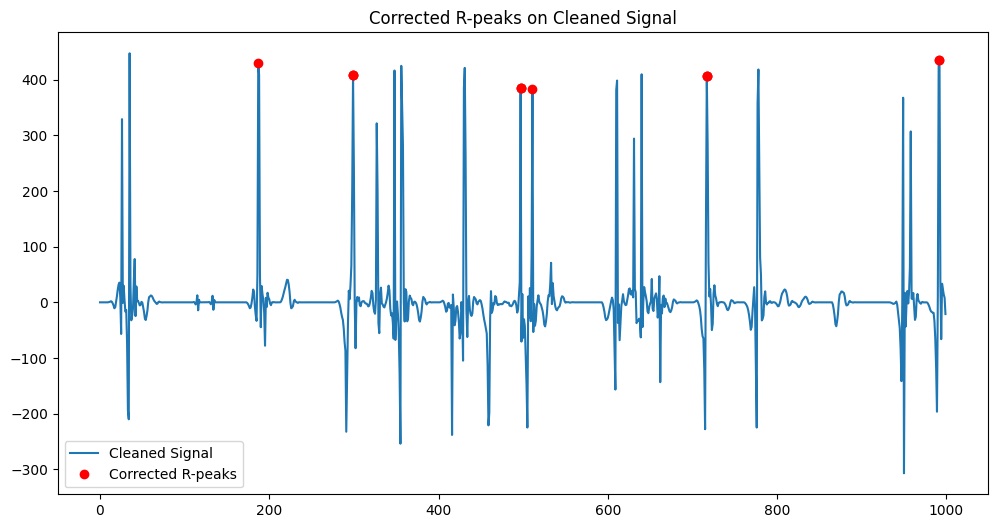

In [11]:
rpeaks = find_rpeaks(subset_clean, fs=fs)
rpeaks_corrected = find_rpeaks_corrected(subset_clean, rpeaks, fs=fs)
# Optional: plot the corrected R-peaks
plt.figure(figsize=(12,6))
plt.plot(subset_clean, label='Cleaned Signal')
plt.plot(rpeaks_corrected, subset_clean[rpeaks_corrected], 'ro', label='Corrected R-peaks')
plt.legend()
plt.title('Corrected R-peaks on Cleaned Signal')
plt.show()  

In [12]:
find_hr(rpeaks, fs=fs)
find_hr(rpeaks_corrected, fs=fs)

'38.5% of the R-peaks are within the range of 45-160'

HR:  73
SDRR: 18
RMSSD:  87


'8.3% of the R-peaks are within the range of 45-160'

HR:  54
SDRR: 0
RMSSD:  112


(array([53.57142857]), np.float64(0.0), np.float64(112.0))